In [1]:
import numpy as np
import os
import tqdm
import torch
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn as nn
import torchvision.models as models
from torchsummary import summary
import optuna
from sklearn.model_selection import train_test_split
from torch.utils.data import WeightedRandomSampler
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, roc_curve
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

In [2]:
class MelSpectogramDataset(Dataset):
    def __init__(self, data_path, transform=None, max_samples_dict=None):
        """
        Initialize the MelSpectogramDataset class.

        Args:
            data_path (str): Path to the folder containing the mel spectrogram files.
            transform (callable): Optional transform to be applied to the mel spectrogram.
            max_samples_dict (dict): Dictionary specifying the maximum number of samples per genre. 
                                     For example: {'rock': 1000, 'pop': 600}.
        """

        self.data_path = data_path
        self.transform = transform
        self.max_samples_dict = max_samples_dict

        # Sort genres alphabetically
        self.genres = sorted([d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))])

        self.file_paths = []
        self.labels = []

        for i, genre in enumerate(self.genres):
            genre_folder = os.path.join(data_path, genre)
            files = [f for f in os.listdir(genre_folder) if f.endswith('.npy')]

            # Check if this genre has a max_samples limit
            if max_samples_dict and genre in max_samples_dict:
                max_samples = max_samples_dict[genre]
                files = np.random.choice(files, size=min(max_samples, len(files)), replace=False).tolist()

            self.file_paths.extend([os.path.join(genre_folder, f) for f in files])
            self.labels.extend([i] * len(files))

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        mel_spectrogram = np.load(self.file_paths[idx])
        label = self.labels[idx]
        
        if self.transform:
            mel_spectrogram = self.transform(mel_spectrogram)

        return mel_spectrogram, label


In [3]:
def calculate_metrics(y_true, y_pred_probs, num_classes):
    """
    Calculate AUC, precision, recall, and F1 score for multiclass classification.

    Args:
        y_true (array-like): True labels.
        y_pred_probs (array-like): Predicted probabilities or logits.
        num_classes (int): Number of classes in the classification task.

    Returns:
        dict: A dictionary containing AUC, precision, recall, and F1 scores.
    """
    # Convert predicted probabilities to class predictions
    y_pred = y_pred_probs.argmax(axis=1)

    # Calculate metrics
    metrics = {
        "AUC": roc_auc_score(y_true, y_pred_probs, multi_class="ovr", average="macro"),
        "Precision": precision_score(y_true, y_pred, average="macro", zero_division=1),
        "Recall": recall_score(y_true, y_pred, average="macro"),
        "F1 Score": f1_score(y_true, y_pred, average="macro")
    }
    return metrics


from sklearn.metrics import classification_report


def per_class_metrics(y_true, y_pred, num_classes):
    """
    Prints classification metrics for each class.

    Args:
        y_true (array-like): True labels.
        y_pred (array-like): Predicted labels.
        num_classes (int): Number of classes in the classification task.
    """
    report = classification_report(
        y_true,
        y_pred,
        zero_division=1,
        target_names=[f"Class {i}" for i in range(num_classes)]
    )
    print(report)

In [4]:
resnet = models.resnet18()
resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=(1, 2), bias=True)
resnet.maxpool = nn.MaxPool2d((2, 3), stride=(1, 2))
resnet.fc = nn.Linear(512, 8)
summary(resnet, (1, 96, 1376))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 64, 90, 685]           3,200
       BatchNorm2d-2          [-1, 64, 90, 685]             128
              ReLU-3          [-1, 64, 90, 685]               0
         MaxPool2d-4          [-1, 64, 89, 342]               0
            Conv2d-5          [-1, 64, 89, 342]          36,864
       BatchNorm2d-6          [-1, 64, 89, 342]             128
              ReLU-7          [-1, 64, 89, 342]               0
            Conv2d-8          [-1, 64, 89, 342]          36,864
       BatchNorm2d-9          [-1, 64, 89, 342]             128
             ReLU-10          [-1, 64, 89, 342]               0
       BasicBlock-11          [-1, 64, 89, 342]               0
           Conv2d-12          [-1, 64, 89, 342]          36,864
      BatchNorm2d-13          [-1, 64, 89, 342]             128
             ReLU-14          [-1, 64, 

In [10]:
# Pop and hiphop are overwhealming rest of the classes because of the dataset imbalance
# Let's try to undersample the dataset genres: pop and hiphop and train again.
# Change the max_samples_dict to undersample pop and hiphop genres in the objective and train the model again.
def objective(trial):
    # Hyperparameters to optimize
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])

    # Create a MelSpectogramDataset instance
    """
    Training the model with stratified split, undersample pop and rock, apply weighted random sampler with Optuna.
    """
    # Create dataset instance

    mel_dataset = MelSpectogramDataset(data_path='spectograms_data')
    print(mel_dataset.genres)  # Check the order of genres (alphabetical)

    # Split the dataset into train, validation and test with 90-5-5 split
    
    # Access file paths and labels
    file_paths = mel_dataset.file_paths
    labels = mel_dataset.labels

    # Split dataset using stratification to train - validate
    train_file_paths, val_file_paths, train_labels, val_labels = train_test_split(
        file_paths, labels, test_size=0.1, random_state=42, stratify=labels
    )

    # Create Datasets for each split
    train_indices = [file_paths.index(path) for path in train_file_paths]
    val_indices = [file_paths.index(path) for path in val_file_paths]

    train_dataset = Subset(mel_dataset, train_indices)
    val_dataset = Subset(mel_dataset, val_indices)

    # Handle imabalanced dataset with WeightedRandomSampler

    # Get train dataset labels
    train_labels = [label for _, label in train_dataset]

    # Get train dataset label count for each class
    class_counts = np.bincount(train_labels)

    # Calculate the class weights
    class_weights = 1.0 / class_counts
    weights = [class_weights[label] for label in train_labels]

    # Create a WeightedRandomSampler
    sampler = WeightedRandomSampler(weights, num_samples=len(train_dataset))

    # Create DataLoader instances
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Set fixed random number of seed
    torch.manual_seed(42)

    # Make use of GPU if available or MPS (Apple) if one is available
    device = (
        "mps"
        if torch.backends.mps.is_built()
        else "cuda"
        if torch.cuda.is_available()
        else "cpu"
    )

    print("Using device:", device)

    # Define the model with dynamic num_filters
    model = resnet.to(device)

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    num_epochs = 3
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        train_progress = tqdm.tqdm(train_loader, desc=f"Training Epoch {epoch + 1}", leave=False)

        for mel_spectrogram, label in train_progress:
            mel_spectrogram, label = mel_spectrogram.to(device).float(), label.to(device)
            optimizer.zero_grad()
            output = model(mel_spectrogram.unsqueeze(1))
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()

            # Update progress bar
            running_loss += loss.item()
            train_progress.set_postfix({"Loss": f"{running_loss / (train_progress.n + 1):.4f}"})

        # Evaluate the CNN model
        model.eval()
        all_labels, all_probs = [], []
        test_progress = tqdm.tqdm(val_loader, desc=f"Testing Epoch {epoch + 1}", leave=False)

        # Use Early Stopping
        with torch.no_grad():
            for mel_spectrogram, label in test_progress:
                mel_spectrogram, label = mel_spectrogram.to(device).float(), label.to(device)
                output = model(mel_spectrogram.unsqueeze(1))
                probabilities = nn.Softmax(dim=1)(output).cpu().numpy()
                all_probs.append(probabilities)
                all_labels.append(label.cpu().numpy())

        # Concatenate all predictions and true labels
        all_labels = np.concatenate(all_labels)
        all_probs = np.concatenate(all_probs)

        # Calculate metrics
        f1 = calculate_metrics(all_labels, all_probs, num_classes=8)["F1 Score"]

        trial.report(f1, epoch)

        # Prune if needed based on the reported F1 score
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

        # Optionally, print the F1 score for each epoch
        print(f"Epoch {epoch + 1} - F1 Score: {f1:.4f}")

    # Return the F1 score after the training loop
    return f1

In [11]:
# Optuna study
study_name = "resnet_optimization_v1_weighted_stratified_alphabetical_normalized"
# Create a file to save study name and my comments on used dataset and hyperparameters
study_comment = "Full dataset. Optimizing learning rate, batch size. No cross-validation used. 90-10 split for training and validation. Stratified split used. WeightedRandomSampler used for training. Labels are sorted alphabetically."
study_comment_file = "study_comment.csv"

# Write new line with study name and comment
with open(study_comment_file, "a") as f:
    f.write(f"\n{study_name},{study_comment}")
# Create an Optuna study
study = optuna.create_study(direction="maximize", storage="sqlite:///db.sqlite3", study_name=study_name,
                            load_if_exists=True)
study.optimize(objective, n_trials=10)

# Best trial
print("Best trial:")
print(f"F1 Score: {study.best_trial.value}")
print(f"Params: {study.best_trial.params}")


[I 2025-01-20 18:34:34,520] Using an existing study with name 'resnet_optimization_v1_weighted_stratified_alphabetical_normalized' instead of creating a new one.


['country', 'hiphop', 'indie', 'jazz', 'metal', 'pop', 'rap', 'rock']
Using device: mps


Epoch 1 - F1 Score: 0.0230


[W 2025-01-20 18:44:32,424] Trial 4 failed with parameters: {'learning_rate': 0.0004297468688422432, 'batch_size': 32} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/julia.rozycka/Master/MTG_Jamendo_dataset/venv/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/var/folders/b9/g8km3d4d6bl780pwnb5dnhxjd5x2_h/T/ipykernel_50443/2292283230.py", line 92, in objective
    running_loss += loss.item()
                    ^^^^^^^^^^^
KeyboardInterrupt
[W 2025-01-20 18:44:32,426] Trial 4 failed with value None.


KeyboardInterrupt: 

In [28]:
best_params = study.best_trial.params

In [6]:
#best_params = {'learning_rate': 1.201780968668489e-05, 'batch_size': 32}
best_params = {'learning_rate': 1.1062787751773096e-05, 'batch_size': 64} #2nd run

In [29]:
model = models.resnet18()
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=(1, 2), bias=True)
model.maxpool = nn.MaxPool2d((2, 3), stride=(1, 2))
model.fc = nn.Linear(512, 8)
summary(model, (1, 96, 1376))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 64, 90, 685]           3,200
       BatchNorm2d-2          [-1, 64, 90, 685]             128
              ReLU-3          [-1, 64, 90, 685]               0
         MaxPool2d-4          [-1, 64, 89, 342]               0
            Conv2d-5          [-1, 64, 89, 342]          36,864
       BatchNorm2d-6          [-1, 64, 89, 342]             128
              ReLU-7          [-1, 64, 89, 342]               0
            Conv2d-8          [-1, 64, 89, 342]          36,864
       BatchNorm2d-9          [-1, 64, 89, 342]             128
             ReLU-10          [-1, 64, 89, 342]               0
       BasicBlock-11          [-1, 64, 89, 342]               0
           Conv2d-12          [-1, 64, 89, 342]          36,864
      BatchNorm2d-13          [-1, 64, 89, 342]             128
             ReLU-14          [-1, 64, 

In [7]:
# Prepare data

mel_dataset = MelSpectogramDataset(data_path='spectograms_data')

# Split the dataset into train, validation and test with 90-5-5 split
# Access file paths and labels
file_paths = mel_dataset.file_paths
labels = mel_dataset.labels

# Split dataset using stratification
train_file_paths, temp_file_paths, train_labels, temp_labels = train_test_split(
    file_paths, labels, test_size=0.1, random_state=42, stratify=labels
)

val_file_paths, test_file_paths, val_labels, test_labels = train_test_split(
    temp_file_paths, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
)

# Create Datasets for each split
train_indices = [file_paths.index(path) for path in train_file_paths]
val_indices = [file_paths.index(path) for path in val_file_paths]
test_indices = [file_paths.index(path) for path in test_file_paths]

train_dataset = Subset(mel_dataset, train_indices)
val_dataset = Subset(mel_dataset, val_indices)
test_dataset = Subset(mel_dataset, test_indices)

# Handle imabalanced dataset with WeightedRandomSampler

# Get train dataset labels
train_labels = [label for _, label in train_dataset]

# Get train dataset label count for each class
class_counts = np.bincount(train_labels)

# Calculate the class weights
class_weights = 1.0 / class_counts
weights = [class_weights[label] for label in train_labels]

# Create a WeightedRandomSampler
sampler = WeightedRandomSampler(weights, num_samples=len(train_dataset))

# Create DataLoader instances
train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=best_params['batch_size'])
test_loader = DataLoader(test_dataset, batch_size=best_params['batch_size'])

In [9]:
# Get number of samples in test_loader

num_samples = 0
for mel_spectrogram, label in test_loader:
    num_samples += mel_spectrogram.size(0)
print(num_samples)

722


In [31]:
# Model

# Define the model with dynamic num_filters
model = model.to("mps")

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['learning_rate'])
# Set fixed random number of seed
torch.manual_seed(42)
    
# Plain training loop without early stopping
num_epochs = 8

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    train_progress = tqdm.tqdm(train_loader, desc=f"Training Epoch {epoch + 1}", leave=False)

    for mel_spectrogram, label in train_progress:
        mel_spectrogram, label = mel_spectrogram.to("mps").float(), label.to("mps")
        optimizer.zero_grad()
        output = model(mel_spectrogram.unsqueeze(1))
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        # Update progress bar
        running_loss += loss.item()
        train_progress.set_postfix({"Loss": f"{running_loss / (train_progress.n + 1):.4f}"})

    # Evaluate the CNN model on the validation set
    model.eval()
    correct, total = 0, 0
    all_labels, all_probs = [], []
    all_labels_per_class, all_probs_per_class = [], []
    test_progress = tqdm.tqdm(val_loader, desc=f"Testing Epoch {epoch + 1}", leave=False)

    with torch.no_grad():
        for mel_spectrogram, label in test_progress:
            mel_spectrogram, label = mel_spectrogram.to("mps").float(), label.to("mps")
            output = model(mel_spectrogram.unsqueeze(1))
            probabilities = nn.Softmax(dim=1)(output).cpu().numpy()
            all_probs.append(probabilities)
            all_labels.append(label.cpu().numpy())
            all_labels_per_class.extend(label.cpu().numpy())
            all_probs_per_class.extend(output.cpu().numpy())
            _, predicted = torch.max(output.data, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()

            # Calculate the loss
            loss = criterion(output, label)
            test_progress.set_postfix({"Loss": f"{loss.item():.4f}"})

    # Concatenate all predictions and true labels
    all_labels = np.concatenate(all_labels)
    all_probs = np.concatenate(all_probs)

    all_labels_per_class = np.array(all_labels_per_class)
    all_probs_per_class = np.array(all_probs_per_class)
    y_pred = all_probs_per_class.argmax(axis=1)
    

    # Per-class metrics
    print(f"Epoch {epoch + 1}:")
    print("PER CLASS METRICS")
    per_class_metrics(all_labels, y_pred, num_classes=8)
    print("OVERALL METRICS")

    # Calculate metrics
    metrics = calculate_metrics(all_labels, all_probs, num_classes=8)
    print(f"Epoch {epoch + 1}: Accuracy: {100 * correct / total:.2f}% | Metrics: {metrics}")
    
# Save this model
torch.save(model.state_dict(), "models/resnet_model_v1_weighted_alphabetical.pt")
# Evaluate the model on the test set


Epoch 1:
PER CLASS METRICS
              precision    recall  f1-score   support

     Class 0       0.08      0.38      0.13        21
     Class 1       0.30      0.23      0.26        73
     Class 2       0.14      0.25      0.18        53
     Class 3       0.34      0.66      0.45        90
     Class 4       0.47      0.66      0.55        44
     Class 5       0.59      0.08      0.14       260
     Class 6       0.05      0.57      0.10         7
     Class 7       0.47      0.33      0.39       173

    accuracy                           0.29       721
   macro avg       0.30      0.39      0.27       721
weighted avg       0.44      0.29      0.28       721

OVERALL METRICS
Epoch 1: Accuracy: 28.71% | Metrics: {'AUC': 0.7848485662639202, 'Precision': 0.3037686727526001, 'Recall': 0.3939487492416641, 'F1 Score': 0.272722623532255}


Epoch 2:
PER CLASS METRICS
              precision    recall  f1-score   support

     Class 0       0.11      0.48      0.18        21
     Class 1       0.34      0.56      0.42        73
     Class 2       0.19      0.26      0.22        53
     Class 3       0.42      0.67      0.52        90
     Class 4       0.37      0.73      0.49        44
     Class 5       0.69      0.08      0.14       260
     Class 6       0.05      0.43      0.08         7
     Class 7       0.44      0.28      0.34       173

    accuracy                           0.32       721
   macro avg       0.33      0.44      0.30       721
weighted avg       0.48      0.32      0.29       721

OVERALL METRICS
Epoch 2: Accuracy: 31.76% | Metrics: {'AUC': 0.8141374233108669, 'Precision': 0.325564827748872, 'Recall': 0.4355820186070867, 'F1 Score': 0.29942289128813837}


Epoch 3:
PER CLASS METRICS
              precision    recall  f1-score   support

     Class 0       0.09      0.76      0.16        21
     Class 1       0.53      0.14      0.22        73
     Class 2       0.24      0.23      0.23        53
     Class 3       0.44      0.71      0.54        90
     Class 4       0.41      0.70      0.52        44
     Class 5       0.68      0.14      0.23       260
     Class 6       0.05      0.71      0.09         7
     Class 7       0.56      0.29      0.38       173

    accuracy                           0.31       721
   macro avg       0.37      0.46      0.30       721
weighted avg       0.53      0.31      0.32       721

OVERALL METRICS
Epoch 3: Accuracy: 31.07% | Metrics: {'AUC': 0.8197825430146229, 'Precision': 0.3733696457428009, 'Recall': 0.4603409146323161, 'F1 Score': 0.29593353597208166}


Epoch 4:
PER CLASS METRICS
              precision    recall  f1-score   support

     Class 0       0.29      0.29      0.29        21
     Class 1       0.34      0.86      0.49        73
     Class 2       0.20      0.36      0.26        53
     Class 3       0.40      0.73      0.52        90
     Class 4       0.45      0.70      0.55        44
     Class 5       0.62      0.19      0.29       260
     Class 6       0.00      0.00      0.00         7
     Class 7       0.62      0.34      0.44       173

    accuracy                           0.41       721
   macro avg       0.37      0.43      0.35       721
weighted avg       0.51      0.41      0.39       721

OVERALL METRICS
Epoch 4: Accuracy: 40.64% | Metrics: {'AUC': 0.8263298200629912, 'Precision': 0.36503398826220534, 'Recall': 0.43408314327194686, 'F1 Score': 0.352970228383212}


Epoch 5:
PER CLASS METRICS
              precision    recall  f1-score   support

     Class 0       0.14      0.52      0.22        21
     Class 1       0.65      0.49      0.56        73
     Class 2       0.16      0.47      0.24        53
     Class 3       0.43      0.82      0.56        90
     Class 4       0.54      0.70      0.61        44
     Class 5       0.63      0.16      0.26       260
     Class 6       0.15      0.57      0.24         7
     Class 7       0.61      0.40      0.48       173

    accuracy                           0.40       721
   macro avg       0.41      0.52      0.40       721
weighted avg       0.54      0.40      0.40       721

OVERALL METRICS
Epoch 5: Accuracy: 40.50% | Metrics: {'AUC': 0.833853679561796, 'Precision': 0.41488936053653785, 'Recall': 0.5184046202898906, 'F1 Score': 0.3977729497220523}


Epoch 6:
PER CLASS METRICS
              precision    recall  f1-score   support

     Class 0       0.15      0.62      0.25        21
     Class 1       0.67      0.66      0.66        73
     Class 2       0.26      0.28      0.27        53
     Class 3       0.31      0.94      0.46        90
     Class 4       0.53      0.66      0.59        44
     Class 5       0.70      0.18      0.28       260
     Class 6       0.06      0.14      0.08         7
     Class 7       0.60      0.32      0.42       173

    accuracy                           0.40       721
   macro avg       0.41      0.48      0.38       721
weighted avg       0.56      0.40      0.39       721

OVERALL METRICS
Epoch 6: Accuracy: 40.50% | Metrics: {'AUC': 0.8233731835407637, 'Precision': 0.40838644848698646, 'Recall': 0.47510442275094644, 'F1 Score': 0.376074747092999}


Epoch 7:
PER CLASS METRICS
              precision    recall  f1-score   support

     Class 0       0.24      0.48      0.32        21
     Class 1       0.36      0.85      0.50        73
     Class 2       0.20      0.32      0.25        53
     Class 3       0.41      0.77      0.53        90
     Class 4       0.54      0.66      0.59        44
     Class 5       0.63      0.20      0.30       260
     Class 6       0.00      0.00      0.00         7
     Class 7       0.58      0.38      0.46       173

    accuracy                           0.42       721
   macro avg       0.37      0.46      0.37       721
weighted avg       0.51      0.42      0.40       721

OVERALL METRICS
Epoch 7: Accuracy: 42.30% | Metrics: {'AUC': 0.8266471230786296, 'Precision': 0.3707679286393838, 'Recall': 0.4566900909494681, 'F1 Score': 0.370383426930419}


Epoch 8:
PER CLASS METRICS
              precision    recall  f1-score   support

     Class 0       0.25      0.57      0.35        21
     Class 1       0.56      0.82      0.67        73
     Class 2       0.17      0.43      0.24        53
     Class 3       0.49      0.81      0.61        90
     Class 4       0.61      0.61      0.61        44
     Class 5       0.67      0.27      0.38       260
     Class 6       0.00      0.00      0.00         7
     Class 7       0.60      0.45      0.51       173

    accuracy                           0.47       721
   macro avg       0.42      0.50      0.42       721
weighted avg       0.56      0.47      0.47       721

OVERALL METRICS
Epoch 8: Accuracy: 47.43% | Metrics: {'AUC': 0.8370980934224198, 'Precision': 0.4196049434811951, 'Recall': 0.4957966991224061, 'F1 Score': 0.42216954163718023}


In [32]:
# Evaluate the model on the test set
test_model = models.resnet18()
test_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=(1, 2), bias=True)
test_model.maxpool = nn.MaxPool2d((2, 3), stride=(1, 2))
test_model.fc = nn.Linear(512, 8)

test_model = test_model.to("mps")


PER CLASS METRICS
              precision    recall  f1-score   support

     Class 0       0.22      0.50      0.31        22
     Class 1       0.49      0.68      0.57        73
     Class 2       0.14      0.38      0.20        53
     Class 3       0.42      0.69      0.52        90
     Class 4       0.60      0.60      0.60        45
     Class 5       0.59      0.27      0.37       260
     Class 6       0.40      0.33      0.36         6
     Class 7       0.65      0.42      0.51       173

    accuracy                           0.43       722
   macro avg       0.44      0.48      0.43       722
weighted avg       0.53      0.43      0.44       722

OVERALL METRICS
Accuracy: 43.35% | Metrics: {'AUC': 0.8562805879279405, 'Precision': 0.43925841618675837, 'Recall': 0.48326022576505706, 'F1 Score': 0.4301251310747946}


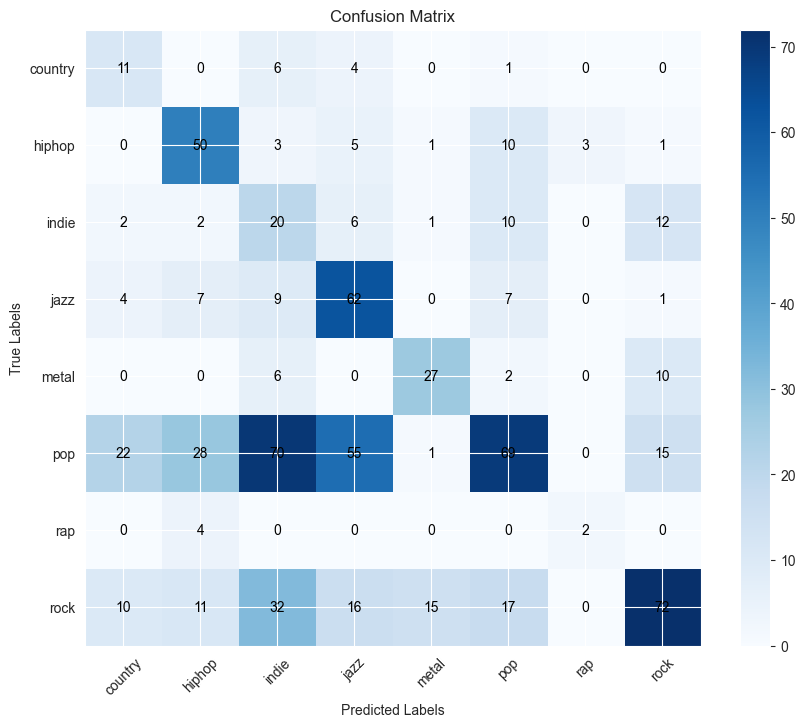

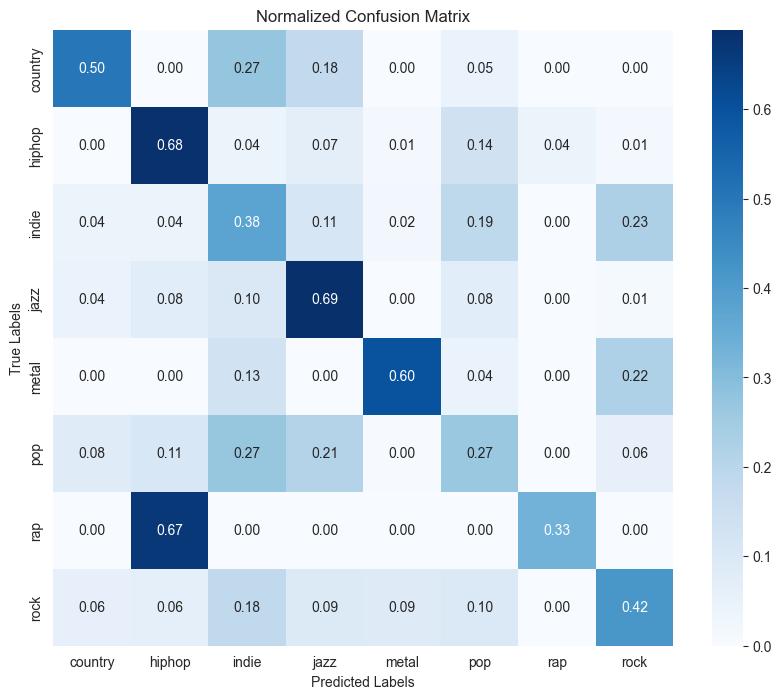

In [33]:

# Load the model weights
test_model.load_state_dict(torch.load("models/resnet_model_v1_weighted_alphabetical.pt", weights_only=True))

# Create a DataLoader instance for the test set
# test_loader = DataLoader(test_dataset, batch_size=32)

test_model.eval()

with torch.no_grad():
    correct, total = 0, 0
    all_labels, all_probs = [], []
    all_labels_per_class, all_probs_per_class = [], []
    test_progress = tqdm.tqdm(test_loader, desc="Testing", leave=False)

    for mel_spectrogram, label in test_progress:
        mel_spectrogram, label = mel_spectrogram.to("mps").float(), label.to("mps")
        output = test_model(mel_spectrogram.unsqueeze(1))
        probabilities = nn.Softmax(dim=1)(output).cpu().numpy()
        all_probs.append(probabilities)
        all_labels.append(label.cpu().numpy())
        all_labels_per_class.extend(label.cpu().numpy())
        all_probs_per_class.extend(output.cpu().numpy())
        _, predicted = torch.max(output.data, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()

        # Calculate the loss
        loss = criterion(output, label)
        test_progress.set_postfix({"Loss": f"{loss.item():.4f}"})

    # Concatenate all predictions and true labels
    all_labels = np.concatenate(all_labels)
    all_probs = np.concatenate(all_probs)

    all_labels_per_class = np.array(all_labels_per_class)
    all_probs_per_class = np.array(all_probs_per_class)
    y_pred = all_probs_per_class.argmax(axis=1)

    # Per-class metrics
    print("PER CLASS METRICS")
    per_class_metrics(all_labels, y_pred, num_classes=8)

    # Calculate metrics
    metrics = calculate_metrics(all_labels, all_probs, num_classes=8)
    print("OVERALL METRICS")

    print(f"Accuracy: {100 * correct / total:.2f}% | Metrics: {metrics}")

# Plot the confusion matrix with annotations on test set
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Calculate the confusion matrix
conf_matrix = confusion_matrix(all_labels, y_pred)

# Plot the confusion matrix with annotations
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, cmap="Blues")
plt.colorbar()
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.xticks(range(8), mel_dataset.genres, rotation=45)
plt.yticks(range(8), mel_dataset.genres)
for i in range(8):
    for j in range(8):
        plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="black")
plt.show()
# Now plot the normalized confusion matrix
import seaborn as sns
conf_matrix_norm = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]



In [38]:
# Capitalize the genre labels
mel_dataset.genres = [genre.capitalize() for genre in mel_dataset.genres]

In [40]:
# Change Hiphop to Hip-Hop
mel_dataset.genres[1] = "Hip-Hop"

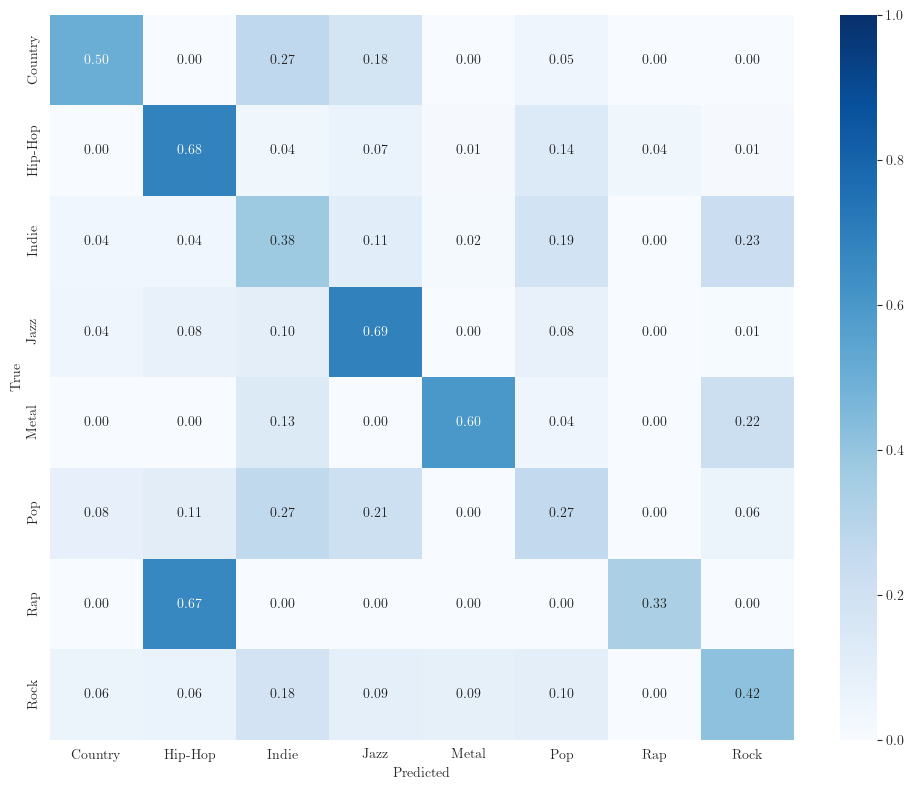

In [41]:
# Normalize the confusion matrix
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
# Plot the normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_norm, cmap="Blues", annot=True, fmt=".2f", xticklabels=mel_dataset.genres,
            yticklabels=mel_dataset.genres, vmax=1.0)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig("confusion_matrix_normalized_resnet.png", dpi=300)
plt.show()

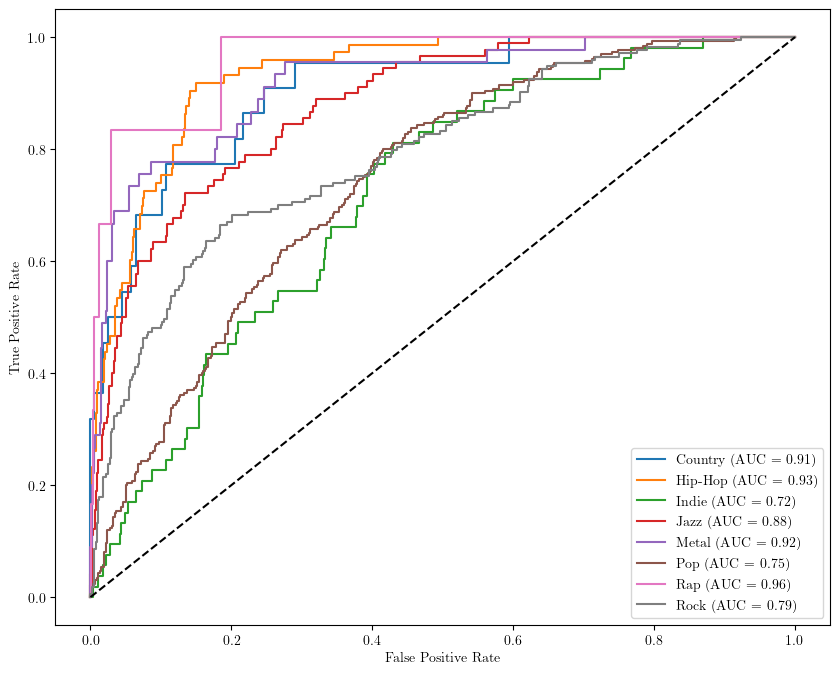

In [50]:

# Get the true positive rate and false positive rate
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(8):
    fpr[i], tpr[i], _ = roc_curve((all_labels == i).astype(int), all_probs[:, i])
    roc_auc[i] = roc_auc_score((all_labels == i).astype(int), all_probs[:, i])
    
# Plot the ROC curve
plt.figure(figsize=(10, 8))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
for i in range(8):
    plt.plot(fpr[i], tpr[i], label=f"{mel_dataset.genres[i]} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
# Make background plain white
plt.style.use('fast')
# Add legend
plt.legend()
plt.savefig("auc_roc_resnet.png", dpi=300)
plt.show()

In [10]:
model = models.resnet18()
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=(1, 2), bias=True)
model.maxpool = nn.MaxPool2d((2, 3), stride=(1, 2))
model.fc = nn.Linear(512, 8)

model.load_state_dict(torch.load("models/resnet_model_v1_weighted_alphabetical.pt", weights_only=True))
model = model.to("mps")

# remove the last layer
model = nn.Sequential(*list(model.children())[:-1])
model.eval()

# extract features
features = []
labels = []

with torch.no_grad():
    for mel_spectrogram, label in tqdm.tqdm(test_loader, desc="Extracting Features", leave=False): # test loader size is 722 samples
        mel_spectrogram, label = mel_spectrogram.to("mps").float(), label.to("mps")
        output = model(mel_spectrogram.unsqueeze(1))
        features.append(output.cpu().numpy())
        labels.append(label.cpu().numpy())

In [14]:
features[0].shape

(64, 512, 1, 1)

In [21]:
features_concat = np.concatenate(features)
labels_concat = np.concatenate(labels)
print(features_concat.shape)
print(labels_concat.shape)

(722, 512, 1, 1)
(722,)


In [23]:
# Show one example of features with label
example_idx = 1

# get example
example_features = features_concat[example_idx]
example_label = labels_concat[example_idx]

# features
print(f"Features shape: {example_features.shape}")

#  label
print(f"Label: {example_label}")

Features shape: (512, 1, 1)
Label: 5


In [24]:
print(example_features)

[[[1.1929476 ]]

 [[1.2066723 ]]

 [[1.6920147 ]]

 [[1.1335827 ]]

 [[0.5402925 ]]

 [[1.4499992 ]]

 [[0.81607276]]

 [[1.1870347 ]]

 [[0.38707235]]

 [[1.0133725 ]]

 [[1.1047418 ]]

 [[1.2742987 ]]

 [[0.8847964 ]]

 [[0.81361187]]

 [[0.94844717]]

 [[0.39616922]]

 [[0.6804931 ]]

 [[0.9309913 ]]

 [[0.50956315]]

 [[0.7300642 ]]

 [[1.0605849 ]]

 [[0.70259136]]

 [[0.866956  ]]

 [[1.1119548 ]]

 [[0.79916084]]

 [[0.66216576]]

 [[0.81890655]]

 [[0.551581  ]]

 [[0.8110934 ]]

 [[1.1637989 ]]

 [[0.86307496]]

 [[1.3293605 ]]

 [[0.8771394 ]]

 [[0.573127  ]]

 [[0.41318986]]

 [[0.57121855]]

 [[1.4193752 ]]

 [[0.80457586]]

 [[0.7027336 ]]

 [[1.120077  ]]

 [[0.56576496]]

 [[0.5001262 ]]

 [[0.97085404]]

 [[0.89306307]]

 [[0.8134908 ]]

 [[0.41545862]]

 [[0.8776354 ]]

 [[0.41115224]]

 [[0.9586717 ]]

 [[0.68363017]]

 [[0.60943925]]

 [[1.1518308 ]]

 [[0.506265  ]]

 [[0.557717  ]]

 [[1.210507  ]]

 [[1.3461984 ]]

 [[0.8195258 ]]

 [[1.1936603 ]]

 [[0.78593147]

In [13]:
text = """
Gatunek muzyczny (definicyjnie) identyfikuje utwory muzyczne jako należące do
wspólnej tradycji lub zbioru konwencji. Nie jest tożsamy z formą muzyczną i stylem
muzycznym, chociaż w praktyce terminy te są niekiedy używane zamiennie. W specy-
fikacji kontenera danych ID3v1 można znaleźć 80 typów gatunków muzycznych, które
z rozszerzeniem programu Winamp obejmują numerację typów gatunków aż do 191
[3, 4]. Mimo że podział muzyki na gatunki jest w dużym stopniu subiektywny,
istnieją kryteria percepcyjne związane z określoną instrumentacją, tempem lub struk-
turą rytmiczną muzyki, jakie mogą posłużyć do scharakteryzowania określonego ga-
tunku [5, 6]. Na podstawie badań subiektywnych wiadomo, że człowiek potrafi prze-
widzieć gatunek muzyczny jedynie na podstawie 250-milisekundowego fragmentu,
jeśli dany gatunek jest mu znany [7]. Może to sugerować, że ludzie potrafią oceniać
gatunki muzyczne jedynie na płaszczyźnie muzycznej, bez konstruowania opisów wyż-
szego poziomu.
Rozpoznawanie gatunku muzycznego jest jednym z podstawowych elementów
inteligentnych systemów tworzenia automatycznych list muzyki. Platformy stru-
mieniowe (streamingowe) oferujące taką usługę wymagają rozwiązań umożliwiających
jak najdokładniejsze określenie przynależności utworu do gatunku muzycznego.
Zgodnie z aktualnym stanem wiedzy najskuteczniejszym klasyfikatorem są sztuczne
sieci neuronowe (w tym w wersji uczenia głębokiego), dla których wejście stanowi
spektrogram (postać 2D wektora wejściowego), współczynniki MFCC czy wektor pa-
rametrów [8–10].
"""
  
# From this text remove character -, newline and multiple spaces 

text = text.replace("\n", " ").replace("-", "").replace("  ", " ")

print(text)
    
    

 Gatunek muzyczny (definicyjnie) identyfikuje utwory muzyczne jako należące do wspólnej tradycji lub zbioru konwencji. Nie jest tożsamy z formą muzyczną i stylem muzycznym, chociaż w praktyce terminy te są niekiedy używane zamiennie. W specy fikacji kontenera danych ID3v1 można znaleźć 80 typów gatunków muzycznych, które z rozszerzeniem programu Winamp obejmują numerację typów gatunków aż do 191 [3, 4]. Mimo że podział muzyki na gatunki jest w dużym stopniu subiektywny, istnieją kryteria percepcyjne związane z określoną instrumentacją, tempem lub struk turą rytmiczną muzyki, jakie mogą posłużyć do scharakteryzowania określonego ga tunku [5, 6]. Na podstawie badań subiektywnych wiadomo, że człowiek potrafi prze widzieć gatunek muzyczny jedynie na podstawie 250milisekundowego fragmentu, jeśli dany gatunek jest mu znany [7]. Może to sugerować, że ludzie potrafią oceniać gatunki muzyczne jedynie na płaszczyźnie muzycznej, bez konstruowania opisów wyż szego poziomu. Rozpoznawanie gatunku mu